In [1]:
import os

os.chdir("..")

In [2]:
from getPoses import load_views, load_patches, normalize_patches, iterative_suppression, transform_patch
from modules.utils import load_array, load_angles, load_annotations
import numpy as np
import scipy.ndimage as ndii

In [3]:
def load_data(rootdir):

    views, patches_names = load_views(os.path.join(rootdir, "views.csv"))
    patches = load_patches(os.path.join(rootdir, "test/cropped/positive"), patches_names).astype(float)

    coords = load_annotations(os.path.join(rootdir, 'coordinates.csv'))[:,2:].astype(float)
    angles = load_angles(os.path.join(rootdir, 'angles.csv'))[:,2:].astype(float)
    translations = coords - np.rint(coords)
    poses = np.concatenate([angles, translations], axis=1).astype(float)

    psf = load_array(os.path.join(rootdir, 'psf.tif'))

    return patches, coords, angles, views, poses, psf

In [4]:
import matplotlib.pyplot as plt

def disp3D(fig, *ims, axis_off=True):
    axes = fig.subplots(2, len(ims)*2)
    if axis_off:
        for ax in axes.reshape(-1): ax.set_axis_off()
    for i in range(len(ims)):
        views = np.array([
            ims[i][ims[i].shape[0]//2,:,:],
            ims[i][:,ims[i].shape[1]//2,:],
            ims[i][:,:,ims[i].shape[2]//2]
        ])
        views = normalize_patches(views)
        axes[0,2*i].imshow(views[0], cmap='gray')
        axes[1,2*i].imshow(views[1], cmap='gray')
        axes[0,2*i+1].imshow(ndii.rotate(views[2], -90)[:,::-1], cmap='gray')

def disp2D(fig, *ims, **imshowkwargs):
    h = int(np.floor(len(ims)**0.5))
    w = int(np.ceil(len(ims)/h))
    axes = fig.subplots(h, w)
    if type(axes) == np.ndarray:
        axes = axes.flatten()
        for ax in axes: ax.set_axis_off()
        for i in range(len(ims)):
            axes[i].imshow(ims[i], **imshowkwargs)
    else:
        axes.set_axis_off()
        axes.imshow(ims[0], **imshowkwargs)

Load perfect data

In [5]:
dirname = "perfect"
rootdir = f"/data/plumail/generated_data/inputs/{dirname}"
patches, coords, angles, views, poses, psf = load_data(rootdir)

In [6]:
patches_2D = patches.sum(axis=1)
patches_2D = normalize_patches(patches_2D)

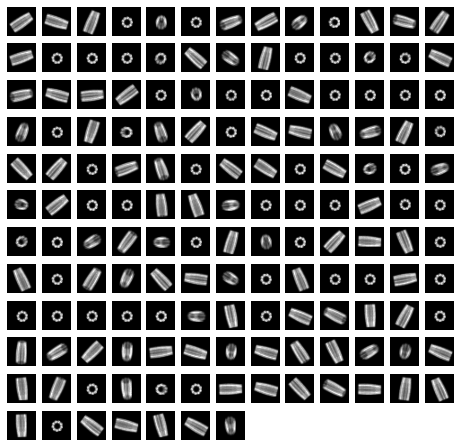

In [7]:
fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_2D, cmap='gray')

In [8]:
%load_ext autoreload
%autoreload 2

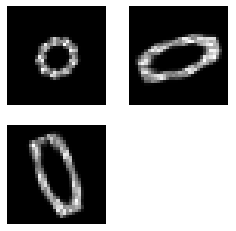

In [9]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, patches[8])

In [10]:
from utils_3d import inverse_affine_transform
import torch

patches_transformed = inverse_affine_transform(torch.as_tensor(patches, device='cuda'), torch.as_tensor(poses, device='cuda')).cpu().numpy()
poses_no_shift = poses.copy()
poses_no_shift[:,3:] = 0.
patches_transformed2 = inverse_affine_transform(torch.as_tensor(patches, device='cuda'), torch.as_tensor(poses_no_shift, device='cuda')).cpu().numpy()

/home/plumail/stage/minisource/utils_3d.py:62: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


In [ ]:
device='cuda'
%timeit reconstruction_L2(torch.as_tensor(patches, device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses, device=device), torch.tensor(lambda_, device=device), 0)

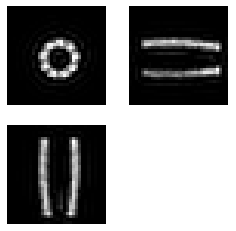

In [11]:
from utils_3d import reconstruction_L2

psf = psf.astype(float)
psf = psf / psf.sum()

lambda_ = 5e-5
device = 'cuda'
recon, den = reconstruction_L2(torch.as_tensor(patches, device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses, device=device), torch.tensor(lambda_, device=device), 0)
fig = plt.figure(figsize=(4,4))
disp3D(fig, recon.cpu().numpy())

In [13]:
device = 'cpu'
%timeit reconstruction_L2(torch.as_tensor(patches[:50], device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses[:50], device=device), torch.tensor(lambda_, device=device), 0)

45.4 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
device = 'cuda'
%timeit reconstruction_L2(torch.as_tensor(patches[:50], device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses[:50], device=device), torch.tensor(lambda_, device=device), 0)

19 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
from utils_3d import affine_transform, pad_to_size, dftregistrationND
import torch

poses_no_shift = poses.copy()
poses_no_shift[:, 3:] = 0
recon_rotated = affine_transform(torch.as_tensor(recon, device='cuda').repeat(poses_no_shift.shape[0],1,1,1), torch.as_tensor(poses_no_shift, device='cuda'))
H = torch.fft.fftn(torch.fft.fftshift(pad_to_size(torch.as_tensor(psf, device='cuda'), torch.Size(patches.shape[1:]))))
recon_rotated_convolved = H.conj() * torch.fft.fftn(torch.as_tensor(recon_rotated, device='cuda'))
patches_freq = torch.fft.fftn(torch.as_tensor(patches, device='cuda'))
error, diffphase, shift = dftregistrationND(recon_rotated_convolved, patches_freq, nb_spatial_dims=3)
shifts = torch.stack(shift, dim=1)

In [13]:
%load_ext memory_profiler

In [14]:
import itertools
from utils_3d import find_angles_grid

device = 'cuda'
dtype = torch.float32
L = 1000
best_poses, errors, precision = find_angles_grid(torch.as_tensor(recon,device=device,dtype=dtype), torch.as_tensor(patches,device=device,dtype=dtype), torch.as_tensor(psf,device=device,dtype=dtype), L=L)
print(precision)

6.422846818149976


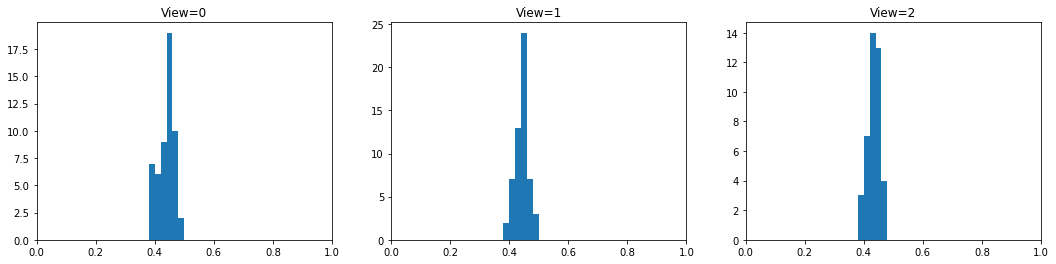

In [15]:
plt.figure(figsize=(6*3,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f"View={i}")
    plt.hist(errors[views==i].cpu().numpy(), bins=np.arange(0,1,0.02))
    plt.xlim(0,1)

Text(0.5, 1.0, 'Cross-correlation error vs angle error')

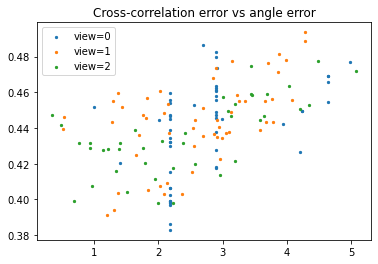

In [16]:
from utils_3d import distance_poses

angle, d = distance_poses(torch.as_tensor(poses, device=best_poses.device, dtype=best_poses.dtype), best_poses)
plt.figure(figsize=(6,4))
for i in range(3):
    #plt.ylim(0.3, 1)
    #plt.xlim(0, 180)
    plt.scatter(np.abs(angle[views==i].cpu().numpy()), errors[views==i].cpu().numpy(), s=5, label=f"view={i}")
plt.legend()
plt.title("Cross-correlation error vs angle error")

(0.0, 180.0)

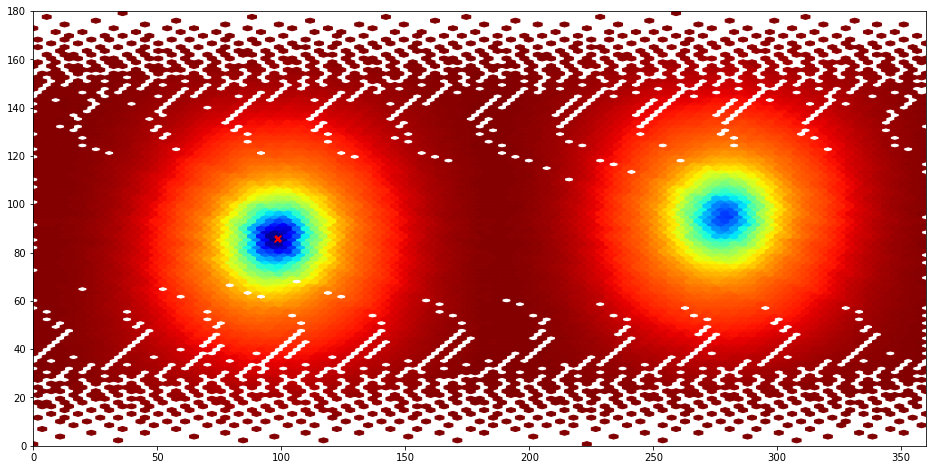

In [188]:
fig = plt.figure(figsize=(16,8))
plt.hexbin(potential_poses[:,2].cpu().numpy(), potential_poses[:,1].cpu().numpy(), errors[:,0].cpu().numpy(), cmap='jet')
plt.scatter(best_pose[0,2].cpu(), best_pose[0,1].cpu(), color='red', marker='x')
plt.scatter(random_poses[0,2], random_poses[0,1], color='red', marker='x')
plt.xlim(0, 360)
plt.ylim(0, 180)

In [241]:
device = 'cuda'
dtype = torch.float32
N = 100
random_angles = np.random.random(size=(100,3)) * 360
random_poses = np.concatenate([random_angles, np.zeros((N,3))], axis=1)
test_patches = affine_transform(recon[None].repeat(N,1,1,1), random_poses)


In [243]:
out = []
L = 2 ** np.arange(5, 13)
for l in L:
    print("L =", l)
    best_poses, errors, precision = find_angles_grid(torch.as_tensor(recon,device=device,dtype=dtype), torch.as_tensor(test_patches,device=device,dtype=dtype), torch.as_tensor(psf,device=device,dtype=dtype), L=l)
    angle, d = distance_poses(torch.as_tensor(random_poses, device=best_poses.device, dtype=best_poses.dtype), best_poses)
    #angle[angle>90] = 180 - angle[angle>90]
    out.append((precision, np.median(angle.cpu().numpy())))

L = 32
L = 64
L = 128
L = 256
L = 512
L = 1024
L = 2048
L = 4096


(0.0, 13.0)

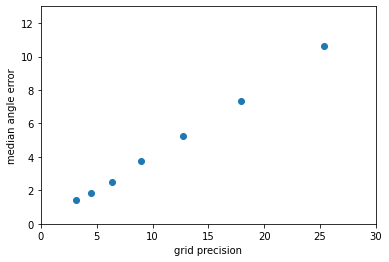

In [245]:
out = np.array(out)
plt.scatter(out[:,0], out[:,1])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('grid precision')
plt.ylabel('median angle error')
plt.xlim(0, 30)
plt.ylim(0, 13)
#plt.plot([0,60], [0,60/3], color='red')

In [ ]:
from utils_3d import refine_poses


guessed_poses = torch.zeros_like(poses)


refine_poses(torch.as_tensor(recon,device=device), patches, psf, guessed_poses, M=20)

In [130]:
device = 'cuda'
%timeit convolution_matching_poses(torch.as_tensor(recon,device=device), torch.as_tensor(patches,device=device), torch.as_tensor(psf,device=device), torch.as_tensor(potential_poses, dtype=torch.float16, device=device))

675 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit out = [phase_cross_correlation(recon_rotated_convolved[i].cpu().numpy(), patches_freq[i].cpu().numpy(), upsample_factor=1, space="fourier", overlap_ratio=0) for i in range(len(patches))]

219 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Reconstruction L2 avec top et side seulement. Information sur l'angle relatif des sides.

[[195.4386371   90.          56.13406557]
 [277.01489872 270.         287.34357331]]


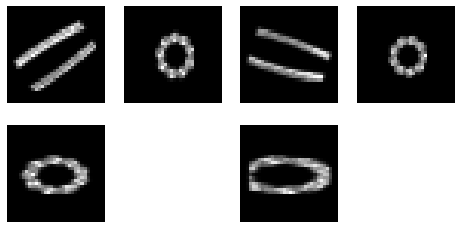

In [17]:
patches_side = patches[views==1]
fig = plt.figure(figsize=(8,4))
print(poses[views==1][[0,1],:3])
disp3D(fig, patches_side[0], patches_side[1])

In [368]:
%timeit reconstruction_L2(torch.as_tensor(patches[mask_top_side],dtype=dtype,device=device), torch.as_tensor(psf,dtype=dtype,device=device), poses_noised[mask_top_side], lambda_)

/home/plumail/stage/minisource/utils_3d.py:62: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


20.7 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


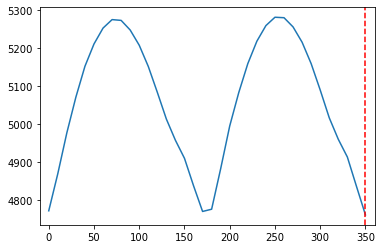

In [18]:
errors = []
recons= []
step = 10
lambda_ = 5e-2
sigma = 20
for delta in torch.arange(0, 360, step):

    poses_noised = torch.as_tensor(poses, device=device, dtype=dtype)
    poses_noised[:, 3:] = 0
    #poses_noised[:, :3] += torch.randn_like(poses_noised[:,:3]) * sigma
    poses_noised[:, 0] = 0
    poses_noised[views==0, 1:3] = 0
    poses_noised[views==1, 1] = 90
    poses_noised[views==1, 2] += delta

    mask_top_side = torch.logical_or(torch.as_tensor(views==0), torch.as_tensor(views==1))
    recon_noised, _ = reconstruction_L2(torch.as_tensor(patches[mask_top_side],dtype=dtype,device=device), torch.as_tensor(psf,dtype=dtype,device=device), poses_noised[mask_top_side], lambda_)
    recons.append(recon_noised)
    
    N = patches[mask_top_side].shape[0]
    recon_noised_transformed = affine_transform(recon_noised[None].repeat(N,1,1,1), poses_noised[mask_top_side])

    error = (((recon_noised_transformed - torch.as_tensor(patches[mask_top_side],dtype=dtype,device=device))**2).view(N,-1).sum(dim=1)**0.5).sum() / N
    errors.append(error.cpu().item())

plt.xlim(-step,360)
x = torch.arange(0, 360, step).cpu().numpy()
errors = np.array(errors)
i = errors.argmin()
plt.plot(x, errors)
plt.axvline(x[i], 0, 1, color='red', ls='--')

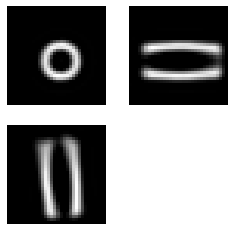

In [19]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, recons[i].cpu().numpy())

Test sur différents niveaux de bruits

In [20]:
import os
import pickle
import glob
import torch

from utils_3d import first_reconstruction

os.chdir('/home/plumail/stage/minisource')

data_dirs = glob.glob("/data/plumail/generated_data/inputs/inputs*")
device = 'cuda'
dtype = torch.float32
out = []
as_tensor = lambda x: torch.as_tensor(x, dtype=dtype, device=device)
for data_dir in data_dirs:
    config_path = os.path.join(data_dir, 'config.pickle')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    patches, coords, angles, views, poses, psf = load_data(data_dir)
    delta, recon, error = first_reconstruction(as_tensor(patches), as_tensor(views), as_tensor(poses), as_tensor(psf), step=1)
    out.append((config.sensor.anisotropic_blur_sigma, config.sensor.gaussian_noise_target_snr_db, delta, recon, error))

/home/plumail/stage/minisource/utils_3d.py:62: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


In [53]:
import pandas as pd

df = pd.DataFrame(list(map(lambda x:(x[0][0],x[1],x[2].cpu().item(),x[4].cpu().item()), out)), columns=["anisotropic_blur","gaussian_nois_snr","delta","error"])
df["delta"] = df["delta"].astype(float) % 180
df.loc[df["delta"] > 90, "delta"] = df[df["delta"] > 90]["delta"] - 180
df.head()

,anisotropic_blur,gaussian_nois_snr,delta,error
0,9.0,11.111111,-2.0,10947.177734
1,8.0,5.555556,-5.0,10654.317383
2,3.0,5.555556,-2.0,8924.691406
3,4.0,0.000000,-2.0,9242.033203
4,10.0,5.555556,-8.0,11575.143555


Text(0, 0.5, 'erreur angle')

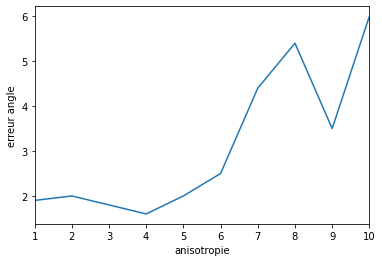

In [66]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('anisotropic_blur').mean()['delta_abs'])
plt.xlim(1, 10)
plt.xlabel("anisotropie")
plt.ylabel("erreur angle")

Text(0, 0.5, 'erreur angle')

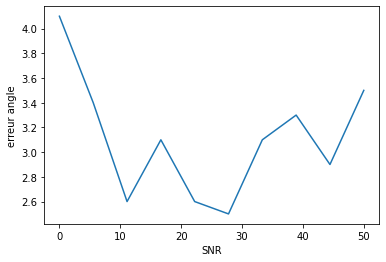

In [74]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('gaussian_nois_snr').mean()['delta_abs'])
#plt.xlim(1, 10)
plt.xlabel("SNR")
plt.ylabel("erreur angle")

(array([13., 49.,  8.,  6.,  0.,  9.,  6.,  3.,  4.,  2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

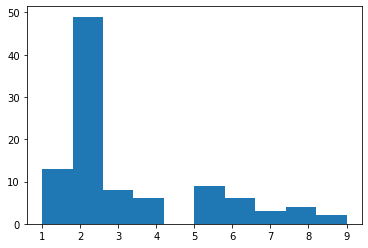

In [55]:
import matplotlib.pyplot as plt

plt.hist(df["delta"].abs())

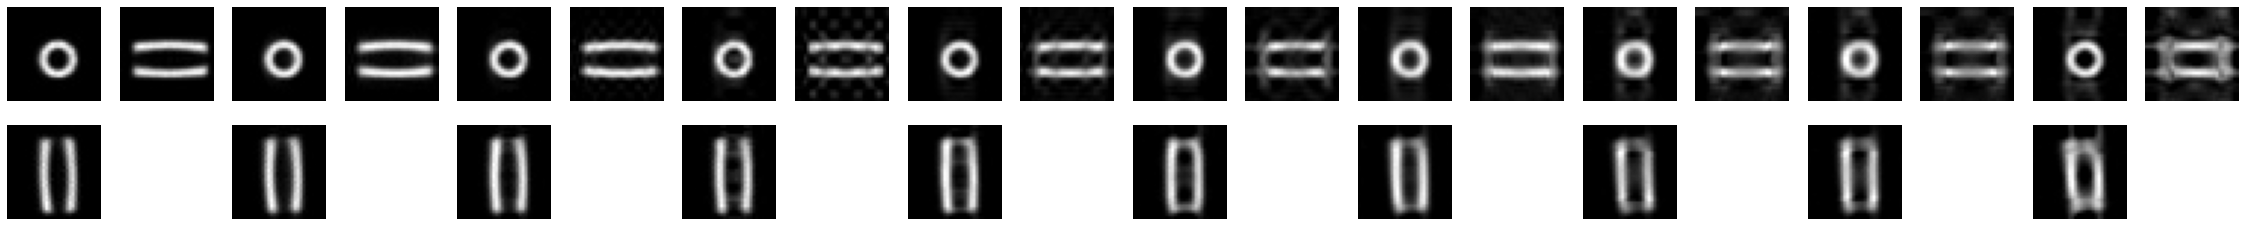

In [64]:
snr_vals = sorted(list(set(map(lambda x:x[1], out))))
recons = list(filter(lambda x:x[1]==snr_vals[0], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

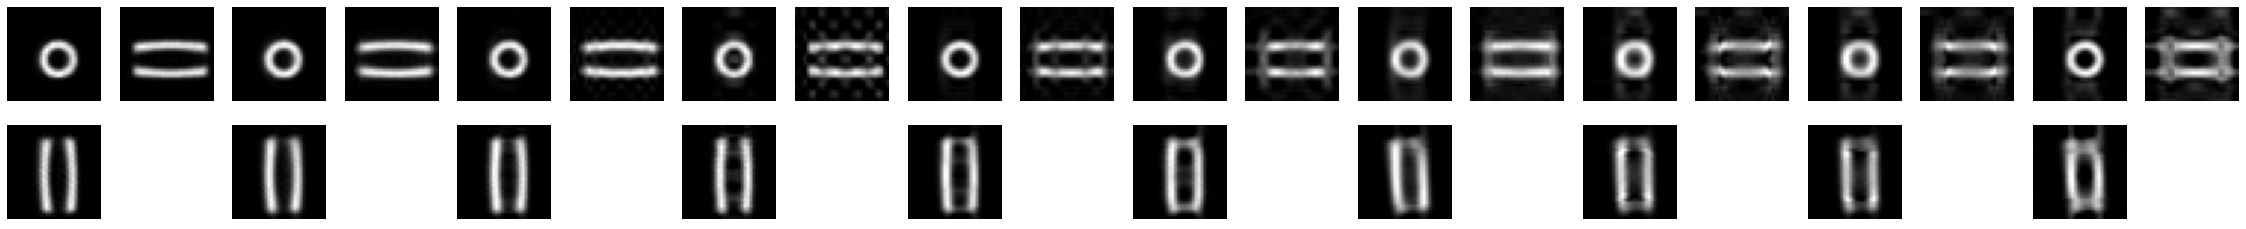

In [65]:
recons = list(filter(lambda x:x[1]==snr_vals[-1], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

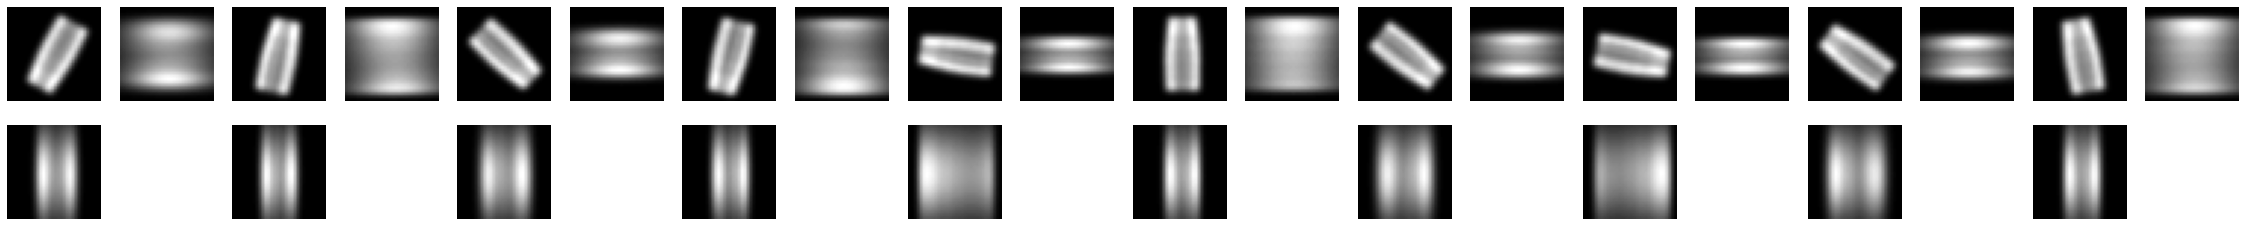

In [72]:
patches, coords, angles, views, poses, psf = load_data("/data/plumail/generated_data/inputs/inputs_blur=10.0_snr=11.11111111111111")
fig = plt.figure(figsize=(4*10,4))
disp3D(fig, *patches[views==1][:10])